In [3]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt

# Functions/Methods

In [285]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        statistic = model[0]
        
        # Dickey-Fuller
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        
        # Augmented Dickey Fuller (ADF)
        if (abs(statistic) > abs(model[4]['1%'])):
            self.perc_stat = 99
        elif (abs(statistic) > abs(model[4]['5%'])):
            self.perc_stat = 95
        elif (abs(statistic) > abs(model[4]['10%'])):
            self.perc_stat = 90
    
        return self.is_stationary;

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0, period=250):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
            
            x = data[x_symbol]
            y = data[y_symbol]
            # filter by period
            y, x = getvalues(y, x, period)
            
            model = model_ols(y, x)
            adf.check(model.resid)
            beta = model.params[1]
            
            # check is stationary
            if (adf.is_stationary):
                rows.append([len(x), y_symbol,x_symbol,adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Period', 'Dependente', 'Independente', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des
        
def analysis_by_periods(y, x):
    rows=[]
    n = len(y)
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        pos = n-period
        y_values = y.iloc[pos:]
        x_values = x.iloc[pos:]
        
        coin = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)
            
        rows.append([period, coin[0], coin[1], coin[2], coin[3], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

def return_varlog(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = np.log(time_series/lag)
    ret[0] = 0
    return ret

def cointegration(y, x, period = 250):
    adf = DickeyFuller()
    n = len(y)
    if (period == 0):
        period = n
    y, x = getvalues(y, x, period)
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

def apply_halflife(data, pairs, period = 250):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues(y, x, period)
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs, period=250):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues(y, x, period)
            
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x, inlog=False):
    if inlog:
        y = return_varlog(y)
        x = return_varlog(x)
    
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs, period=250):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues(y, x, period)
            
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Short/Long'
        zcurrent = zscore_up
    else:
        desc = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs, period=250):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''    
    
    for i, row in pairs.iterrows():
        y, x = getvalues(data[row['Dependente']], data[row['Independente']], period)
        
        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]

def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y, x = getvalues(data[y_symbol], data[x_symbol], period)
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary]

def getvalues(y, x, period):
    if(period > 0):
        pos = len(y)-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    return y, x

def show(data, y_symbol, x_symbol, period=0):
    y, x = getvalues(data[y_symbol], data[x_symbol], period)
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [264]:
path_data_cart = 'datasets/data_cart.csv'
path_data_full = 'datasets/data.csv'
path_data_alpha = 'datasets/data_alpha.csv'

In [265]:
df = pd.read_csv(path_data_alpha, index_col=0)#[['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3']]
data = df[df.columns.difference(['Data', 'Date'])]
data.shape

(300, 74)

In [266]:
pairs = find_cointegrated_pairs(data)
pairs.head()

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta
0,250,ABEV3,BBDC3,0.039492,95,0.437220
1,250,ABEV3,BBDC4,0.024821,95,0.405465
2,250,ABEV3,BBSE3,0.048395,95,0.601511
3,250,ABEV3,BRFS3,0.013458,95,0.357224
4,250,ABEV3,COGN3,0.035040,95,0.987470


In [267]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

Half-Life applied successfully


In [268]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [269]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [270]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [271]:
pairs.head(3)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.039492,95,0.437220,10,0.399379,0.932070,0.240367,Short/Long
1,250,ABEV3,BBDC4,0.024821,95,0.405465,10,0.388354,0.930822,0.258794,Short/Long
2,250,ABEV3,BBSE3,0.048395,95,0.601511,11,0.304081,0.893608,0.043755,Short/Long


In [272]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Analysis

In [273]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(329, 11)

In [274]:
df_hurst = pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
df_hurst

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.039492,95,0.437220,10,0.399379,0.932070,0.240367,Short/Long
1,250,ABEV3,BBDC4,0.024821,95,0.405465,10,0.388354,0.930822,0.258794,Short/Long
2,250,ABEV3,BBSE3,0.048395,95,0.601511,11,0.304081,0.893608,0.043755,Short/Long
3,250,ABEV3,BRFS3,0.013458,95,0.357224,9,0.386506,0.931566,0.020494,Short/Long
4,250,ABEV3,COGN3,0.035040,95,0.987470,10,0.322867,0.946005,0.008871,Short/Long
...,...,...,...,...,...,...,...,...,...,...,...
324,250,TAEE11,YDUQ3,0.002282,99,0.155166,4,0.257279,0.902951,0.398247,Short/Long
325,250,TOTS3,VIVT4,0.000019,99,3.962896,4,0.176730,0.878768,1.108069,Long/Short
326,250,UGPA3,VIVT4,0.015810,95,0.778514,13,0.355734,0.759001,0.276763,Short/Long
327,250,USIM5,VIVT4,0.018127,95,0.342090,13,0.274070,0.726038,0.039455,Long/Short


In [275]:
corr = df_hurst.loc[(df_hurst['Corr'] >= 0.70)]
corr

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.039492,95,0.437220,10,0.399379,0.932070,0.240367,Short/Long
1,250,ABEV3,BBDC4,0.024821,95,0.405465,10,0.388354,0.930822,0.258794,Short/Long
2,250,ABEV3,BBSE3,0.048395,95,0.601511,11,0.304081,0.893608,0.043755,Short/Long
3,250,ABEV3,BRFS3,0.013458,95,0.357224,9,0.386506,0.931566,0.020494,Short/Long
4,250,ABEV3,COGN3,0.035040,95,0.987470,10,0.322867,0.946005,0.008871,Short/Long
...,...,...,...,...,...,...,...,...,...,...,...
324,250,TAEE11,YDUQ3,0.002282,99,0.155166,4,0.257279,0.902951,0.398247,Short/Long
325,250,TOTS3,VIVT4,0.000019,99,3.962896,4,0.176730,0.878768,1.108069,Long/Short
326,250,UGPA3,VIVT4,0.015810,95,0.778514,13,0.355734,0.759001,0.276763,Short/Long
327,250,USIM5,VIVT4,0.018127,95,0.342090,13,0.274070,0.726038,0.039455,Long/Short


#### Pares sinalizando entrada

In [276]:
signal = corr.loc[(df_hurst['Signal'] >= 0.95)].copy()
signal.reset_index(drop=True, inplace=True)
apply_periods(data, signal)

In [278]:
# somente pares cointegrados em no mínimo 3 períodos
signal.loc[(signal['PeriodQt'] > 2)].sort_values(by=['HalfLife'], ascending=True)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,PeriodQt,PeriodStr
5,250,EQTL3,YDUQ3,0.000182,99,0.269111,4,0.190675,0.945751,1.280958,Short/Long,9,"100,120,140,160,180,200,220,240,250"
8,250,TOTS3,VIVT4,0.000019,99,3.962896,4,0.176730,0.878768,1.108069,Long/Short,9,"100,120,140,160,180,200,220,240,250"
6,250,LREN3,SBSP3,0.010652,95,0.861911,8,0.192963,0.902532,1.116641,Long/Short,6,"120,140,160,220,240,250"
0,250,BPAC11,CCRO3,0.040115,95,5.180676,9,0.362485,0.899406,1.018427,Short/Long,5,"120,140,160,240,250"
2,250,CYRE3,SBSP3,0.005576,99,0.739225,10,0.240257,0.922712,1.078510,Long/Short,7,"140,160,180,200,220,240,250"
4,250,ENGI11,MULT3,0.046824,95,0.961218,10,0.370127,0.866236,1.103902,Short/Long,4,"100,220,240,250"
7,250,MULT3,SBSP3,0.032489,95,0.540450,14,0.247684,0.878100,1.461786,Long/Short,5,"160,200,220,240,250"


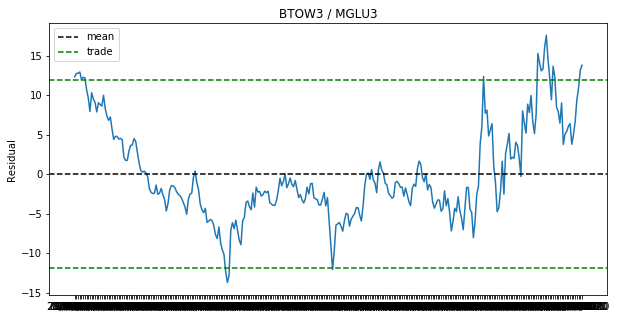

In [283]:
#show(data, 'CYRE3', 'MULT3')
show(data, 'BTOW3', 'MGLU3')

In [284]:
analysis_by_periods(data['BTOW3'], data['MGLU3'])

,Period,Stationary,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr
0,100,False,0.362554,NaN,1.429813,9,0.308937,0.899919
1,120,False,0.351139,NaN,1.435535,10,0.301794,0.893872
2,140,False,0.243217,NaN,1.487543,10,0.305011,0.897522
3,160,False,0.208712,NaN,1.545600,10,0.301499,0.898983
4,180,False,0.156127,NaN,1.541401,10,0.319764,0.915610
5,200,False,0.095544,90.0,1.554738,9,0.315937,0.931274
6,220,False,0.061354,90.0,1.618385,9,0.319420,0.938664
7,240,True,0.049029,90.0,1.583248,9,0.343084,0.949202
8,250,True,0.048947,90.0,1.563635,10,0.338307,0.953287
